In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

# Let's build an attention maps

In [2]:
# !pip install torchsummary

In [3]:
#IMPORTS
from tqdm.notebook import tqdm

import torch
import torchvision
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary
import requests
from PIL import Image
import os
import io
import base64

In [7]:
import sys
sys.path.append(os.path.abspath("../../skin_cancer_nas")) # go to parent dir
sys.path.append(os.path.abspath("/mnt/skin_cancer_nas/data"))
sys.path.append(os.path.abspath("/mnt/skin_cancer_nas/data/torch_generator"))
sys.path.append(os.path.abspath("/mnt/skin_cancer_nas/nas/darts_torch"))

sys.path.append('/mnt')
sys.path.append('/mnt/skin_cancer_nas')
sys.path.append('/mnt/skin_cancer_nas/data/torch_generator')
from skin_cancer_nas.data.torch_generator import generator as data_gen
from skin_cancer_nas.data.torch_generator import base_classes
from skin_cancer_nas.data.torch_generator.config import *

from nas.darts_torch import *
import cv2



ROOT_PATHS = [  Path('/mnt/data/interim/_melanoma_20200728_REGISTERED_OCV_WHITE_Split_Channels/checkyourskin'),
                Path('/mnt/data/interim/_melanoma_20200728_REGISTERED_OCV_WHITE_Split_Channels/loc'),
                Path('/mnt/data/interim/_melanoma_20200728_REGISTERED_OCV_WHITE_Split_Channels/loc_old_colored')]

CLS1 = ClassesDefinition(root_folders_list=ROOT_PATHS, diagnoses_names_list=['c43', 'd03', 'd03.9'], class_name='Melanoma_like_lesions', int_label=0)
CLS2 = ClassesDefinition(root_folders_list=ROOT_PATHS, diagnoses_names_list=['d22', 'd81', 'l81.2','l81.4', 'q82.5'], class_name='Pigmented_benign', int_label=1)
CLS3 = ClassesDefinition(root_folders_list=ROOT_PATHS, diagnoses_names_list=['d86.3', 'l21', 'l57', 'l57.0', 'l82', 'l85', 'l85.1', 'l85.5', 'l85.8', 'q80'], class_name='Keratin_lesions', int_label=2)
CLS4 = ClassesDefinition(root_folders_list=ROOT_PATHS, diagnoses_names_list=['c44', 'c46', 'd09'], class_name='Nonmelanoma_skin_cancer', int_label=3)

CLASSES_SET_1 = [CLS1, CLS2]
CLASSES_SET_2 = [CLS1, CLS2, CLS3]
CLASSES_SET_3 = [CLS1, CLS2, CLS3, CLS4]
CLASSES_SET_4 = [ \
    ClassesDefinition(root_folders_list=ROOT_PATHS, diagnoses_names_list=['c43'], class_name='Melanoma', int_label=0), \
    ClassesDefinition(root_folders_list=ROOT_PATHS, diagnoses_names_list=['d22'], class_name='Nevuss', int_label=1) \
]
CLASSES_SET_5 = [ \
    ClassesDefinition(root_folders_list=ROOT_PATHS, diagnoses_names_list=['c43'], class_name='Melanoma', int_label=0), \
    ClassesDefinition(root_folders_list=ROOT_PATHS, diagnoses_names_list=['d22'], class_name='Nevuss', int_label=1), \
    ClassesDefinition(root_folders_list=ROOT_PATHS, diagnoses_names_list=['l82'], class_name='Keratin lesion', int_label=2) \
]
CLASSES_SET_6 = [ \
   ClassesDefinition(root_folders_list=ROOT_PATHS, diagnoses_names_list=['c43'], class_name='Melanoma', int_label=0), \
   ClassesDefinition(root_folders_list=ROOT_PATHS, diagnoses_names_list=['c44'], class_name='NonMelanomaCancer', int_label=1), \
   ClassesDefinition(root_folders_list=ROOT_PATHS, diagnoses_names_list=['d22'], class_name='Nevuss', int_label=2) \
]

VALID_CHANNELS = ['r-r', 'ir-r', 'g-g', 'uv-0-r', 'uv-0-g', 'white-g']

IMG_WIDTH = 128
IMG_HEIGHT = 128
VALUE_MISSING = 0
MISSING_CH_IMG = np.ones((IMG_HEIGHT, IMG_WIDTH)) * VALUE_MISSING

In [8]:
import logging
logger = logging.getLogger('skin_cancer_nas__darts__attention_notebook')

### Load model

In [5]:
# Load model
device = 'cpu'

model = torch.load("/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered/5lrs_2oct_ClassSet6_registered/epoch_467_model1.pt")
model.to(device)
for param in model.parameters():
    param.requires_grad = False

### Data preparation

In [9]:
partition, labels = data_gen.train_val_split(val_ratio=0.1, classes_list=CLASSES_SET_5)
classes_num = len(CLASSES_SET_6)


def get_input_output_from_path(sample_path, labels):
    '''
    Generates one sample of data
    '''
    try:
        # logger.info('Sample path={}'.format(sample_path))
        x_out = _convert_img_to_array(sample_path)
        x_out = x_out.astype('float32')
        x_out /= 255

        X = torch.as_tensor(x_out)
        y = labels[str(sample_path)]

        X = X.to(device)
        y = torch.tensor(y).to(device)
        return X, y
    except Exception as e:
        msg = 'Something went wrong at path={}, e={}'.format(sample_path, e)
        print(msg)
        logger.info(msg)


def _convert_img_to_array(sample_path):
    'Converts n grayscale images to 3D array with n channels'
    x_array = []
    for channel in VALID_CHANNELS:
        channel_path = os.path.join(sample_path, channel)
        if not os.path.exists(channel_path):
            x_array.append(MISSING_CH_IMG)
            continue
        image = os.listdir(channel_path)
        if not image:
            x_array.append(MISSING_CH_IMG)
            continue
        full_image_path = os.path.join(channel_path, image[0])
        img = cv2.imread(full_image_path, flags=cv2.IMREAD_GRAYSCALE)
        if img is None:
            x_array.append(MISSING_CH_IMG)
            continue
        else:
            shape = img.shape
            # logger.info(shape)
            img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH), interpolation=cv2.INTER_CUBIC)

        x_array.append(img)

    return np.stack(x_array, axis=0)

! IMPORTANT ! - for now we don't have any image transformations (like normalization), but once they will be - they have to be added here!

In [10]:
X, y = get_input_output_from_path(sample_path=partition['validation'][0], labels=labels)
# X.requires_grad_()

### Calculate saliency (attention) maps

In [11]:
def get_saliencies(X, model, classes_num):
    '''
    inputs:
        X: - image torch tensor (preprocessed if needed)
        model: torch model
        classes_num: number of classes (last layer size)
    returns:
        saliencies: list of activations (6, img_width, img_height), 6 channels as we have four inputs, these can be summed up for visualization
        score_max_index: winning score index (index of saliency map (and neuron), that had highest output)
    '''
    # Copy input
    X_orig = X.detach().clone()
    
    # we would run the model in evaluation mode
    model.eval()
    saliencies = []
    for score_indx in range(classes_num):
        X = X_orig.detach().clone()
        # we need to find the gradient with respect to the input image, so we need to call requires_grad_ on it
        X.requires_grad_()

        '''
        forward pass through the model to get the scores, note that VGG-19 model doesn't perform softmax at the end
        and we also don't need softmax, we need scores, so that's perfect for us.
        '''
        scores = model(X.unsqueeze(0))

        # Get the index corresponding to the maximum score and the maximum score itself.
        score_max_index = scores.argmax()
        score_to_analize = scores[0, score_indx]

        '''
        backward function on score_max performs the backward pass in the computation graph and calculates the gradient of 
        score_to_analize with respect to nodes in the computation graph
        '''
        score_to_analize.backward()

        '''
        Saliency would be the gradient with respect to the input image now. But note that the input image has 3 channels,
        R, G and B. To derive a single class saliency value for each pixel (i, j),  we take the maximum magnitude
        across all colour channels.
        '''
        # saliency, _ = torch.max(X.grad.data.abs(), dim=0)
    #     saliency = torch.sum(X.grad.data.abs(), dim=0)
        saliencies.append(X.grad.data.abs().detach().numpy())
        
    return saliencies, score_max_index.detach().numpy().item()

In [12]:
# saliencies, score_max_index = get_saliencies(X, model, classes_num=5)

In [13]:
# imshow(np.sum(saliencies[2], axis=0), cmap=plt.cm.hot)

### Gallery

In [14]:
class FlowLayout(object):
    ''' A class / object to display plots in a horizontal / flow layout below a cell '''
    def __init__(self):
        # string buffer for the HTML: initially some CSS; images to be appended
        self.sHtml =  """
        <style>
        .floating-box {
        display: inline-block;
        margin: 10px;
        border: 3px solid #888888;  
        }
        </style>
        """

    def add_plot(self, oAxes):
        ''' Saves a PNG representation of a Matplotlib Axes object '''
        Bio=io.BytesIO() # bytes buffer for the plot
        fig = oAxes.get_figure()
        fig.canvas.print_png(Bio) # make a png of the plot in the buffer

        # encode the bytes as string using base 64 
        sB64Img = base64.b64encode(Bio.getvalue()).decode()
        self.sHtml+= (
            '<div class="floating-box">'+ 
            '<img src="data:image/png;base64,{}\n">'.format(sB64Img)+
            '</div>')

    def PassHtmlToCell(self):
        ''' Final step - display the accumulated HTML '''
        display(HTML(self.sHtml))

In [15]:
def display_gallery(X_list, y_list, paths_list, saliencies_list, score_max_index_list):
    
    assert len(X_list) == len(y_list)
    assert len(X_list) == len(paths_list)
    assert len(X_list) == len(saliencies_list)
    assert len(X_list) == len(score_max_index_list)
    
    full_list = zip(X_list, y_list, paths_list, saliencies_list, score_max_index_list)
    
    classified_ok = list(filter(lambda s: s[1] == s[4],full_list))
    classified_nok = list(filter(lambda s: s[1] != s[4],full_list))
    classified_nok = sorted(classified_nok, key = lambda x: x[4]) 
    
    def display_zipped_list(zipped_list):
        for X, y, path, saliencies, score_max_index in tqdm(zipped_list):

            path = path.replace('/mnt/data/interim/_melanoma_20200728_REGISTERED_OCV_WHITE_Split_Channels', '')

            # Display image channels ##################################################################
            for i in range(6):  #we have 6 channels
                fig, ax1 = plt.subplots(1, 1, figsize=fig_size)
                ax1.imshow(X[i], cmap=plt.cm.gray)
#                 ax1.title.set_text('true_y={}, chan={}, \n{}, '.format(y, i, path))
                ax1.title.set_text('Sal.chan.={}, true_y={}'.format(i, y))
                oPlot.add_plot(ax1) # pass it to the FlowLayout to save as an image
                plt.close()

            # Display saliency channels for winning class  ##################################################################
            saliency_max = saliencies[score_max_index]
            for i in range(6):  #we have 6 channels
                fig, ax2 = plt.subplots(1, 1, figsize=fig_size)
                ax2.imshow(saliency_max[i], cmap=plt.cm.hot)
                ax2.title.set_text('Sal.chan.={}, pred_y={}'.format(i, score_max_index))
                oPlot.add_plot(ax2) # pass it to the FlowLayout to save as an image
                plt.close()

        oPlot.PassHtmlToCell()
    
    print('Incorrectly classified samples:')
    oPlot = FlowLayout() # create an empty FlowLayout
    fig_size = (3,3)
    print(len(classified_nok))
    display_zipped_list(classified_nok)
    
    print('Correctly classified samples:')
    oPlot = FlowLayout() # create an empty FlowLayout
    fig_size = (3,3)
    print(len(classified_ok))
    display_zipped_list(classified_ok)
    

In [16]:
# Gather list of input 'image' matrices, labels and paths (for titles)
X_list = []
y_list = []  # y_true
paths_list = []
saliencies_list = []
score_max_index_list = []  # y_pred
len_val = len(partition['validation'])
print(len_val)
for i in tqdm(range(len_val)):
    sample_path = partition['validation'][i]
    _X, _y = get_input_output_from_path(sample_path=sample_path, labels=labels)
    X_list.append(_X)
    y_list.append(_y)
    paths_list.append(sample_path)
    
    saliencies, score_max_index = get_saliencies(_X, model, classes_num=classes_num)
    saliencies_list.append(saliencies)
    score_max_index_list.append(score_max_index)

59


Incorrectly classified samples:
0


Correctly classified samples:
13



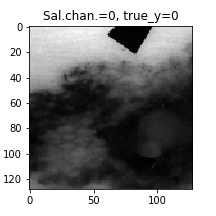
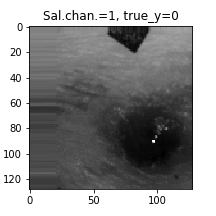
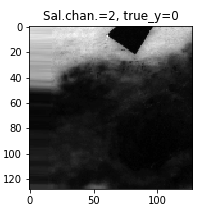
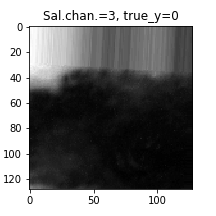
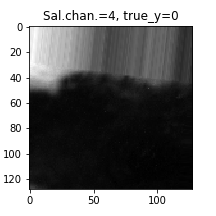
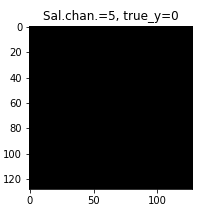
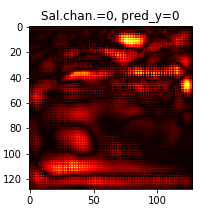
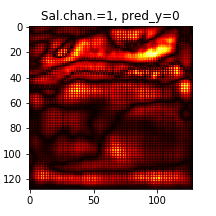
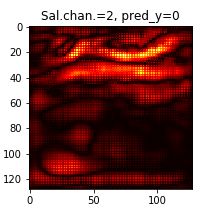
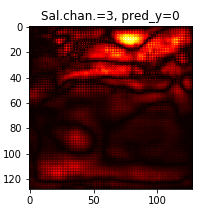
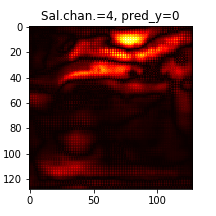
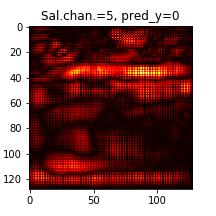
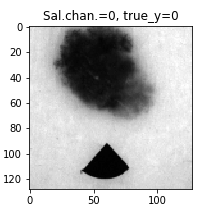
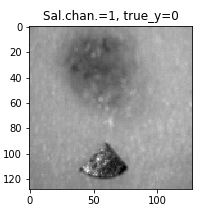
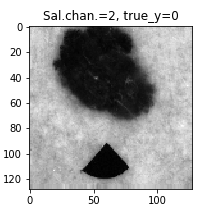
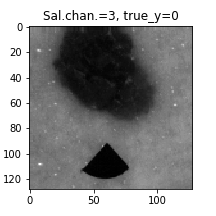
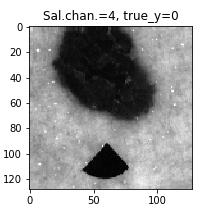
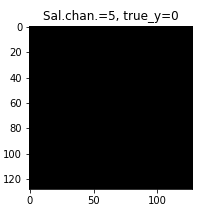
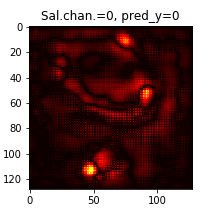
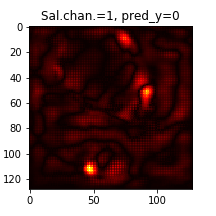
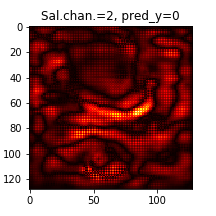
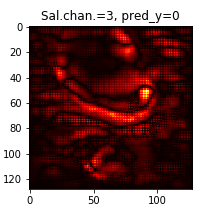
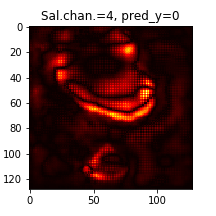
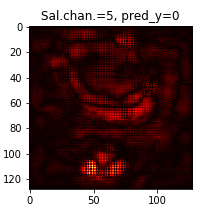
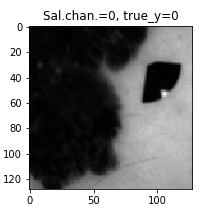
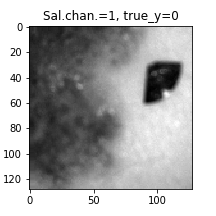
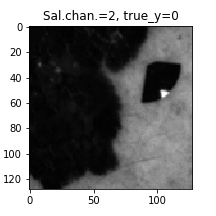
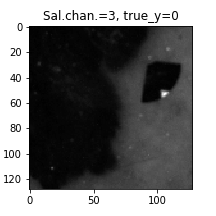
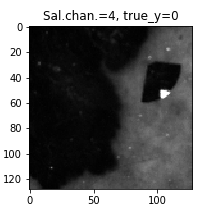
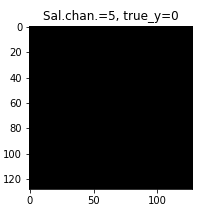
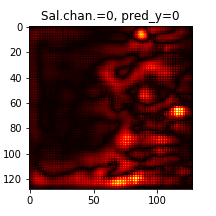
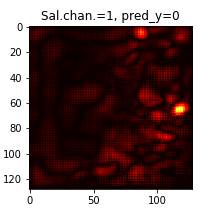
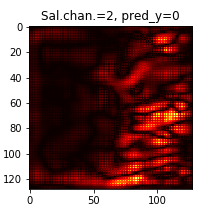
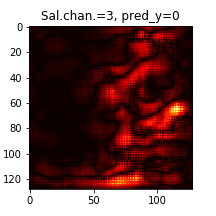
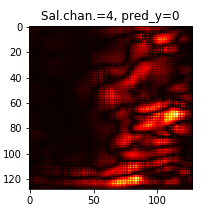
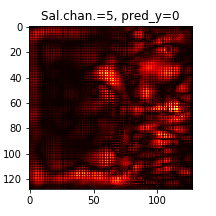
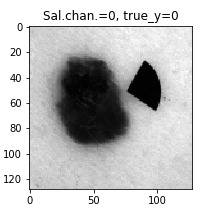
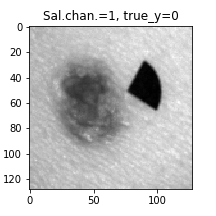
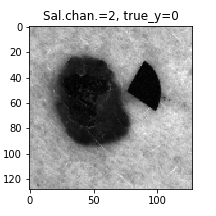
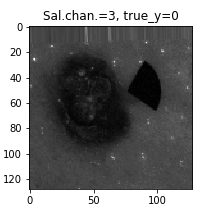
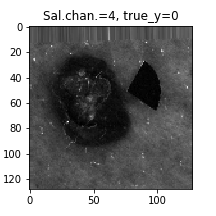
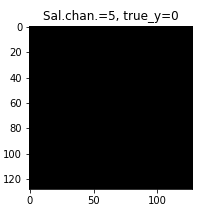
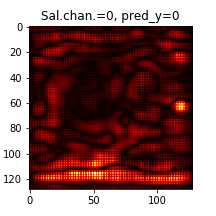
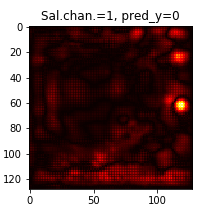
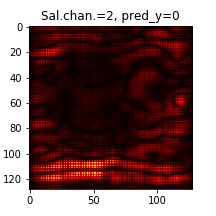
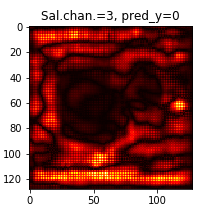
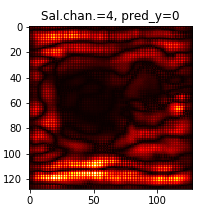
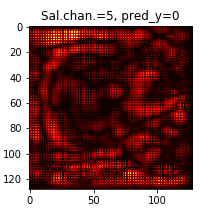
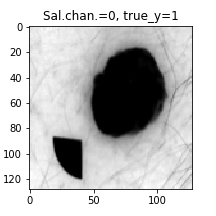
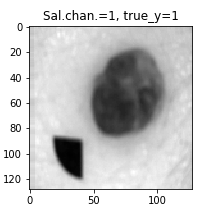
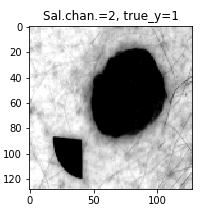
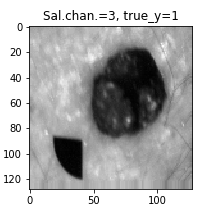
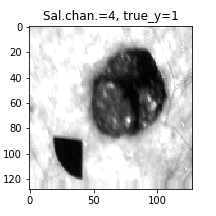
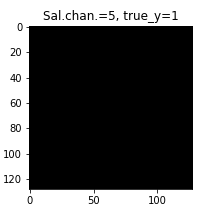
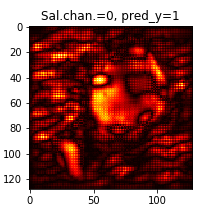
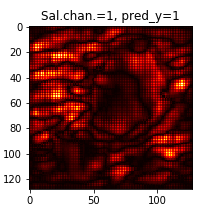
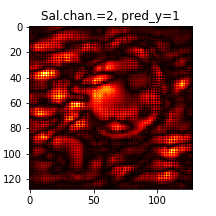
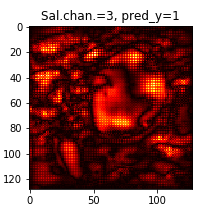
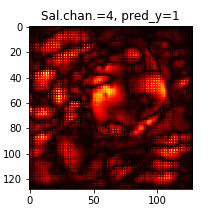
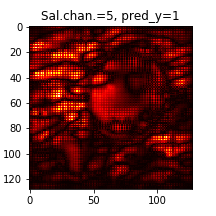
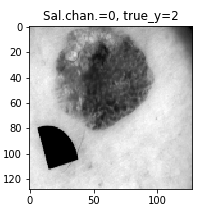
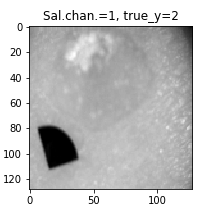
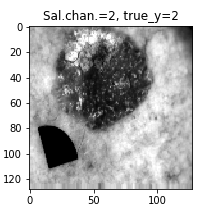
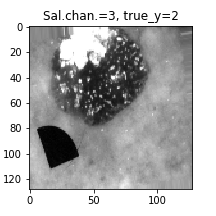
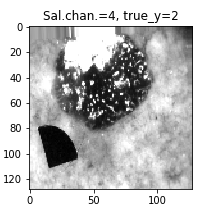
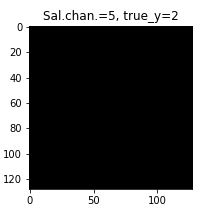
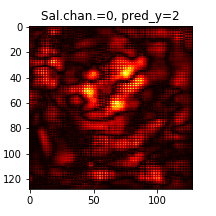
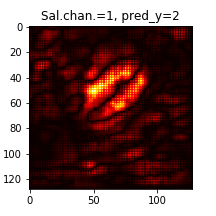
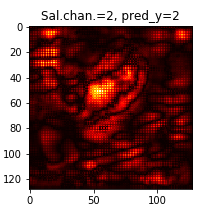
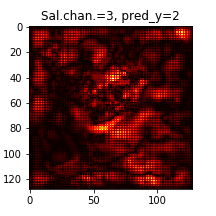
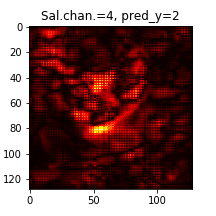
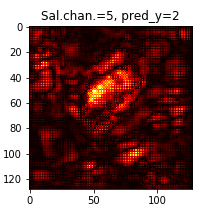
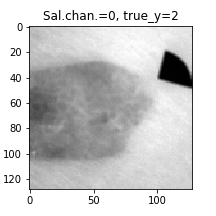
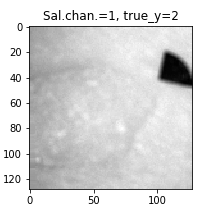
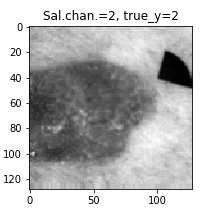
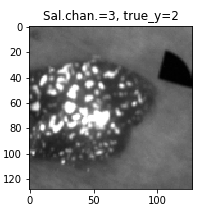
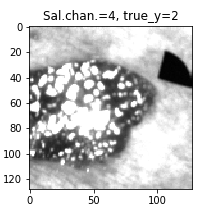
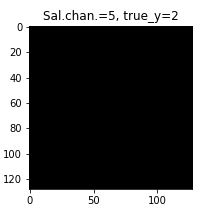
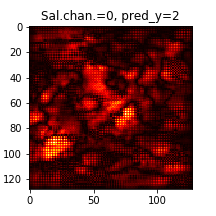
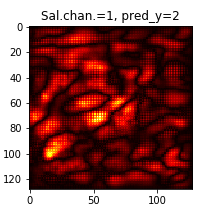
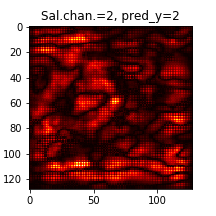
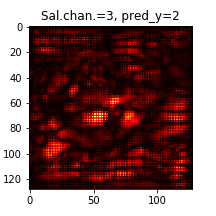
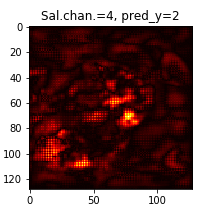
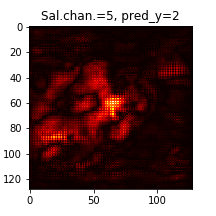
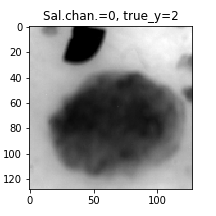
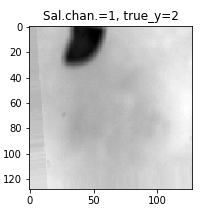
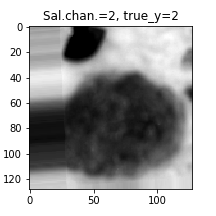
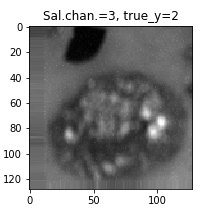
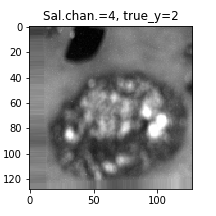
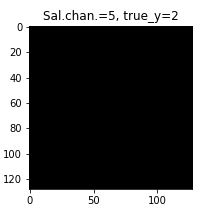
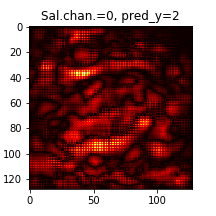
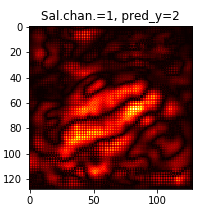
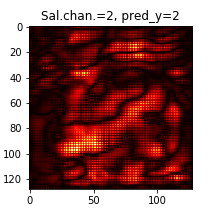
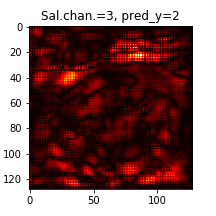
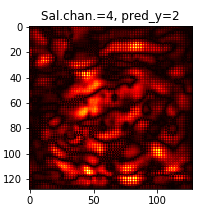
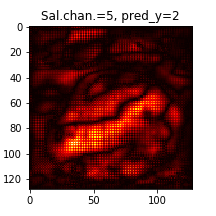
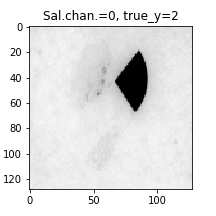
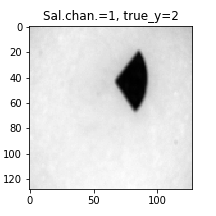
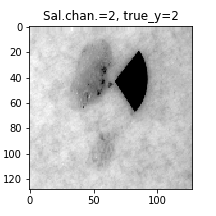
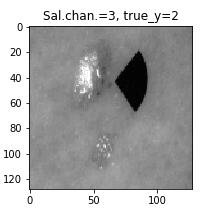
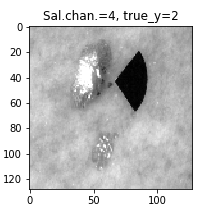
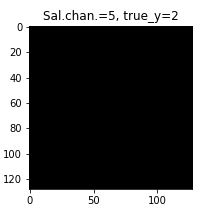
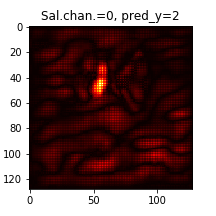
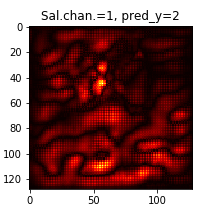
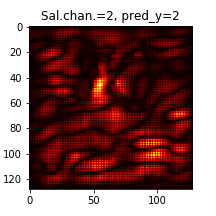
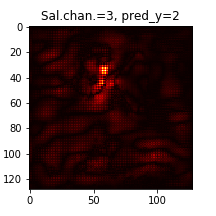
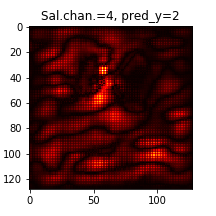
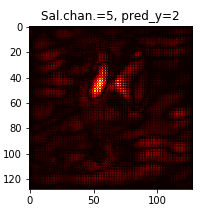
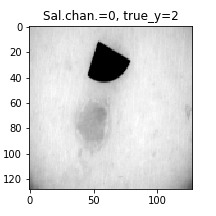
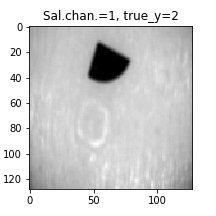
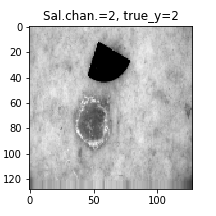
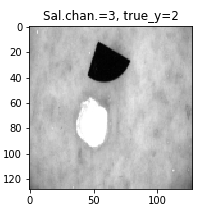
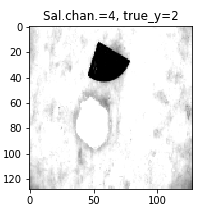
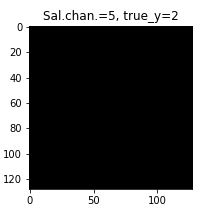
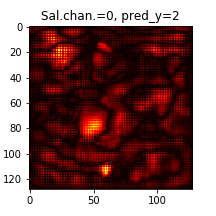
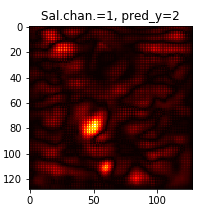
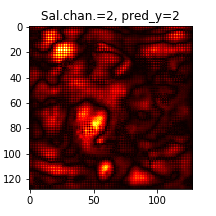
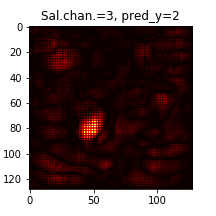
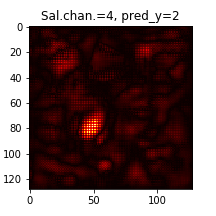
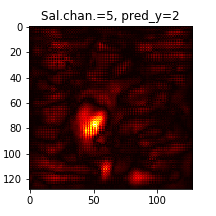
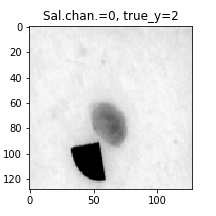
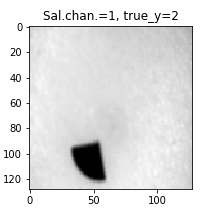
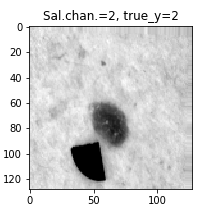
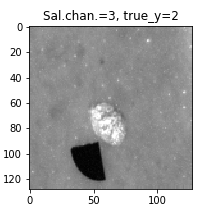
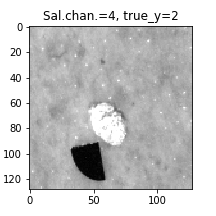
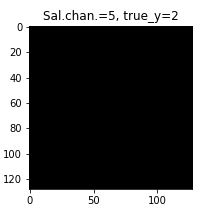
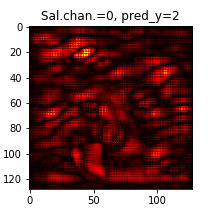
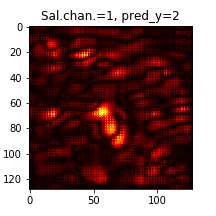
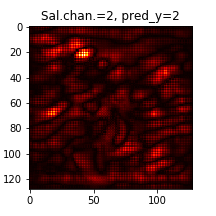
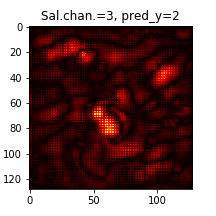
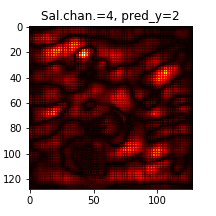
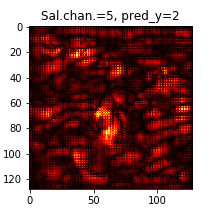
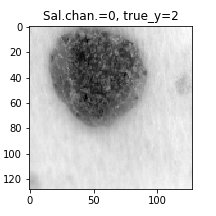
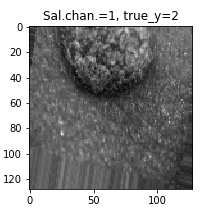
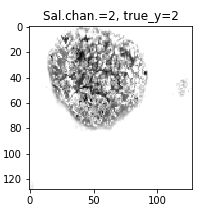
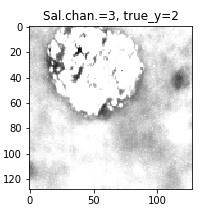
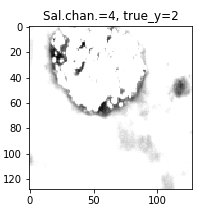
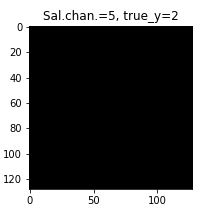
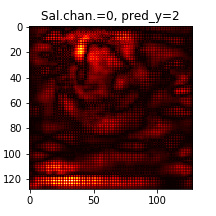
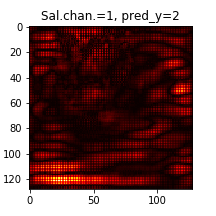
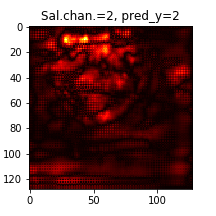
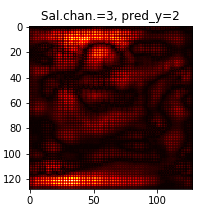
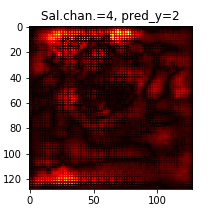
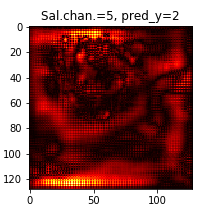
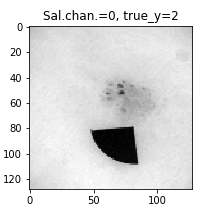
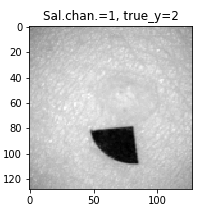
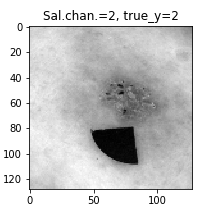
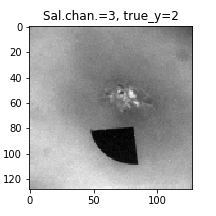
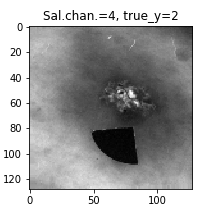
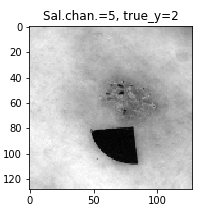
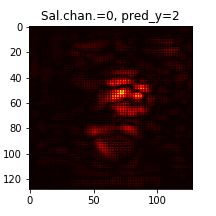
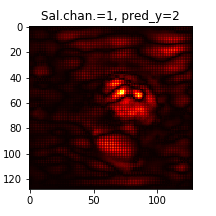
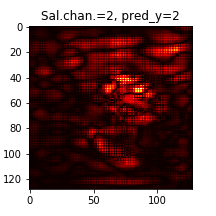
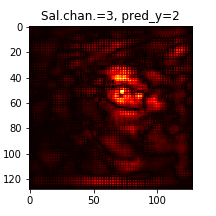
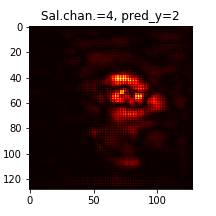
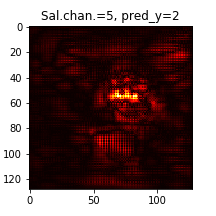

In [17]:
# Firstly 6 channels, then 6 channels of saliency map for winning class (which might be wrong! - check true_y Vs pred_y !)
display_gallery(X_list, y_list, paths_list, saliencies_list, score_max_index_list)

## Visualize model

In [18]:
import torch
from torchviz import make_dot

# x=torch.ones(10, requires_grad=True)
# weights = {'x':x}

# y=x**2
# z=x**3
# r=(y+z).sum()

d = make_dot(model)#.render("attached")

AttributeError: 'CNN' object has no attribute 'grad_fn'

In [ ]:
d